In [1]:
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
import skimage as ski
import tqdm
import pandas as pd
import scipy.stats

imageSize = 250

primaryImage = np.load('subBeadPackPy250_justSpheres.npy')
secondaryImage = np.load('finalSimFile3D250.npy')
primaryImage[primaryImage == 255] = 1

primaryImage = np.transpose(primaryImage)
secondaryImage = np.transpose(secondaryImage)

velSecondaryMat = sio.loadmat('velNormSecondary.mat')
velDataNormSecondary = velSecondaryMat['velNorm']

velPrimaryMat = sio.loadmat('velNormPrimary.mat')
velDataNormPrimary = velPrimaryMat['velNorm']

resolution = 16.81E-6 # adding resolution in meters

# Plot pore space and velocity

Plot the sample with secondary porosity

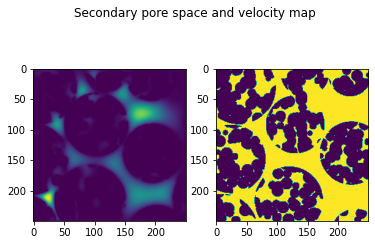

In [2]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormSecondary[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

fig.savefig('secondaryPoreImage.png')


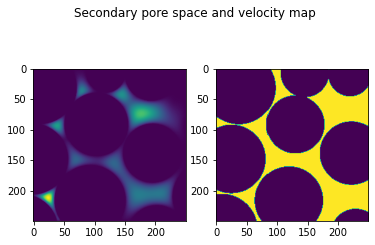

In [3]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormPrimary[:,:,slice])
p2.imshow(primaryImage[:,:,slice])

fig.savefig('primaryPoreImage.png')

# Extract pore network information

In [4]:
snowFiltSecondary = ps.filters.snow_partitioning(im=secondaryImage,r_max=4,sigma=0.4, return_all=True)
poreInfoSecondary = ps.networks.regions_to_network(snowFiltSecondary.regions, dt=snowFiltSecondary.dt)

nRegions = np.unique(snowFiltSecondary.regions).size
secondaryPoreDiamVec = np.zeros(nRegions,)

for a in range(0, poreInfoSecondary['pore.diameter'].size):
    secondaryPoreDiamVec[a] = poreInfoSecondary['pore.diameter'][a]

secondaryRegions = snowFiltSecondary.regions

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1436
Peaks after trimming saddle points:  938
Peaks after trimming nearby peaks:  922
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 922/922 [00:09<00:00, 95.27it/s] 


In [7]:
snowFiltPrimary = ps.filters.snow_partitioning(im=primaryImage,r_max=4,sigma=0.4, return_all=True)
poreInfoPrimary = ps.networks.regions_to_network(snowFiltPrimary.regions, dt=snowFiltPrimary.dt)

nRegions = np.unique(snowFiltPrimary.regions).size
primaryPoreDiamVec = np.zeros(nRegions,)

for a in range(0, poreInfoPrimary['pore.diameter'].size):
    primaryPoreDiamVec[a] = poreInfoPrimary['pore.diameter'][a]

primaryRegions = snowFiltPrimary.regions

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  113
Peaks after trimming saddle points:  104
Peaks after trimming nearby peaks:  93
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 93/93 [00:05<00:00, 18.18it/s]


In [ ]:
ps.io.to_vtk(secondaryRegions,'snowRegionsSecondary')
ps.io.to_vtk(primaryRegions,'snowRegionsPrimary')

# Plot distribution of pore diameter

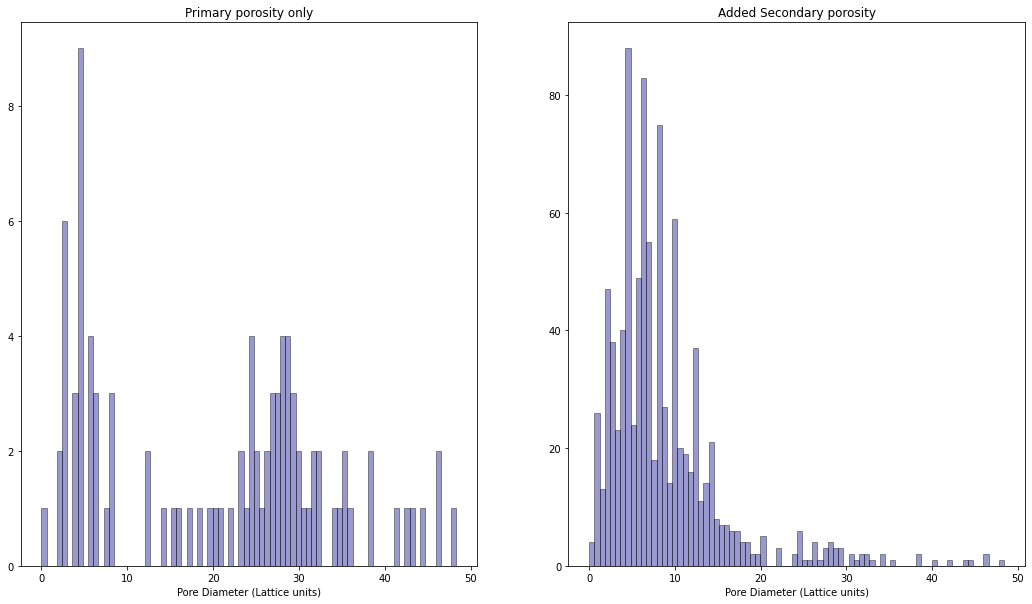

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.distplot(primaryPoreDiamVec, ax=axes[0], hist=True, kde=False,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[0].set_title('Primary porosity only')
axes[0].set_xlabel('Pore Diameter (Lattice units)')

sns.distplot(secondaryPoreDiamVec, ax=axes[1], hist=True, kde=False,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[1].set_title('Added Secondary porosity')
axes[1].set_xlabel('Pore Diameter (Lattice units)')

fig.savefig('poreDiamHist.png')

### I will say pore diameter > 20 units are "big pores"

# Skeleton implementation

Find skeleton for secondary image and collect info

In [74]:
# Skeleton for secondary image
cubeSize = len(secondaryImage)
visit = np.zeros(len(np.unique(secondaryRegions)))
secondaryPoreDiamImage = np.zeros(secondaryImage.shape)
allSecondaryRegions = np.unique(secondaryRegions)
tempImage = np.zeros(secondaryRegions.shape)
secondaryPoreDiamVectorSkeleton = np.zeros(len(allSecondaryRegions))

secondarySkelImage = ski.morphology.skeletonize(secondaryImage)

for a in tqdm.tqdm(range(0,len(allSecondaryRegions)), 'Main loop'):
            regionLabel = a
            if regionLabel != 0: # Don't want grains to be counted
                if visit[regionLabel] == 0:
                    visit[regionLabel] = 1
                    # Adjust indices for pore information, regionlabel = 0 is pore 1 in poreInfo
                    poreDiam = secondaryPoreDiamVec[regionLabel - 1]
                    secondaryPoreDiamImage[secondaryRegions == regionLabel] = poreDiam


Main loop: 100%|██████████| 923/923 [00:15<00:00, 58.53it/s]


In [75]:
# Skeleton for primary image
cubeSize = len(primaryImage)
visit = np.zeros(len(np.unique(primaryRegions)))
primaryPoreDiamImage = np.zeros(primaryImage.shape)
allPrimaryRegions = np.unique(primaryRegions)
tempImage = np.zeros(primaryRegions.shape)
primaryPoreDiamVectorSkeleton = np.zeros(len(allPrimaryRegions))

primarySkelImage = ski.morphology.skeletonize(primaryImage)

for a in tqdm.tqdm(range(0,len(allPrimaryRegions)), 'Main loop'):
            regionLabel = a
            if regionLabel != 0: # Don't want grains to be counted
                if visit[regionLabel] == 0:
                    visit[regionLabel] = 1
                    # Adjust indices for pore information, regionlabel = 0 is pore 1 in poreInfo
                    poreDiam = primaryPoreDiamVec[regionLabel - 1]
                    primaryPoreDiamImage[primaryRegions == regionLabel] = poreDiam



Main loop: 100%|██████████| 94/94 [00:01<00:00, 57.83it/s]


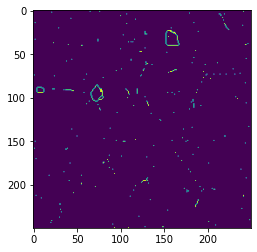

In [77]:
#secondarySkelImage[secondaryImage == 0] = 0
ps.io.to_vtk(secondarySkelImage,'secondarySkeletonWholeImage')
plt.imshow(secondarySkelImage[:,:,40])

secondaryImageOut = np.copy(secondaryImage)
secondaryImageOut = secondaryImageOut.astype(int)
secondaryImageOut[secondaryImage == 1] = 255
ps.io.to_vtk(secondaryImageOut,'secondaryImage')

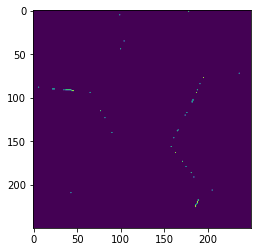

In [78]:
#################################################################
ps.io.to_vtk(primarySkelImage,'primarySkeletonWholeImage')
plt.imshow(primarySkelImage[:,:,40])

primaryImageOut = np.copy(primaryImage)
primaryImageOut = primaryImageOut.astype(int)
primaryImageOut[primaryImage == 1] = 255
ps.io.to_vtk(primaryImageOut,'primaryImage')

# Now plot velocitites on skeleton and extract information

In [11]:
secondaryVelocitiesSkeleton = []
secondaryPoreDiamSkeleton = []
secondaryPoreRegionSkeleton = []

for a in tqdm.tqdm(range(0,cubeSize), 'Secondary porosity loop'):
    for b in range(0,cubeSize):
        for c in range(0, cubeSize):
            # If the primary skeleton image is not zero, then save the velocity data
            # The primary skeleton image will be zero for all indices except the skeleton found above which
            # should be the values in the middle of all of the pores, no pore walls etc...
            # This array should contain the velocity data we want to use to define flow/no flow etc...
            if secondarySkelImage[a,b,c] != 0:
                secondaryVelocitiesSkeleton = np.append(secondaryVelocitiesSkeleton,velDataNormSecondary[a,b,c])
                secondaryPoreDiamSkeleton = np.append(secondaryPoreDiamSkeleton, secondaryPoreDiamImage[a,b,c])
                secondaryPoreRegionSkeleton = np.append(secondaryPoreRegionSkeleton, secondaryRegions[a,b,c])

Main loop: 100%|██████████| 250/250 [00:42<00:00,  5.93it/s]


In [79]:
primaryVelocitiesSkeleton = []
primaryPoreDiamSkeleton = []
primaryPoreRegionSkeleton = []

for a in tqdm.tqdm(range(0,cubeSize), 'Primary porosity loop'):
    for b in range(0,cubeSize):
        for c in range(0, cubeSize):
            # If the primary skeleton image is not zero, then save the velocity data
            # The primary skeleton image will be zero for all indices except the skeleton found above which
            # should be the values in the middle of all of the pores, no pore walls etc...
            # This array should contain the velocity data we want to use to define flow/no flow etc...
            if primarySkelImage[a,b,c] != 0:
                primaryVelocitiesSkeleton = np.append(primaryVelocitiesSkeleton,velDataNormPrimary[a,b,c])
                primaryPoreDiamSkeleton = np.append(primaryPoreDiamSkeleton, primaryPoreDiamImage[a,b,c])
                primaryPoreRegionSkeleton = np.append(primaryPoreRegionSkeleton, primaryRegions[a,b,c])

Primary porosity loop: 100%|██████████| 250/250 [00:36<00:00,  6.87it/s]


# Plot pore velocities with pore diameters

Try taking computing a representative velocity threshold (use interquartile range)

In [80]:
secondary_IQR_PoreVelocity =  []
secondaryMeanPoreVelocity =  []
secondarySkeletonPoreDiam = []
secondarySkeletonPoreRegion = []

for a in tqdm.tqdm(range(0, len(allSecondaryRegions)), 'Main Loop'):
    currentRegion = a
    if currentRegion != 0:
        skeletonPoreVel = secondaryVelocitiesSkeleton[secondaryPoreRegionSkeleton == currentRegion]
        secondaryMeanPoreVelocity = np.append(secondaryMeanPoreVelocity, np.mean(skeletonPoreVel))
        secondary_IQR_PoreVelocity = np.append(secondary_IQR_PoreVelocity, scipy.stats.iqr(skeletonPoreVel, interpolation = 'midpoint'))

        # Adjust indices between regionProps and snow algorithm
        secondarySkeletonPoreDiam = np.append(secondarySkeletonPoreDiam, poreInfoSecondary['pore.diameter'][currentRegion-1] )

        secondarySkeletonPoreRegion = np.append(secondarySkeletonPoreRegion, currentRegion)

Main Loop:   0%|          | 0/923 [00:00<?, ?it/s]E:\Conda\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
Main Loop: 100%|██████████| 923/923 [00:00<00:00, 4350.22it/s]


In [81]:
primary_IQR_PoreVelocity =  []
primaryMeanPoreVelocity =  []
primarySkeletonPoreDiam = []
primarySkeletonPoreRegion = []

for a in tqdm.tqdm(range(0, len(allPrimaryRegions)), 'Main Loop'):
    currentRegion = a
    if currentRegion != 0:
        skeletonPoreVel = primaryVelocitiesSkeleton[primaryPoreRegionSkeleton == currentRegion]
        primaryMeanPoreVelocity = np.append(primaryMeanPoreVelocity, np.mean(skeletonPoreVel))
        primary_IQR_PoreVelocity = np.append(primary_IQR_PoreVelocity, scipy.stats.iqr(skeletonPoreVel, interpolation = 'midpoint'))

        # Adjust indices between regionProps and snow algorithm
        primarySkeletonPoreDiam = np.append(primarySkeletonPoreDiam, poreInfoPrimary['pore.diameter'][currentRegion-1] )

        primarySkeletonPoreRegion = np.append(primarySkeletonPoreRegion, currentRegion)

Main Loop:   0%|          | 0/94 [00:00<?, ?it/s]E:\Conda\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
Main Loop: 100%|██████████| 94/94 [00:00<00:00, 5217.76it/s]


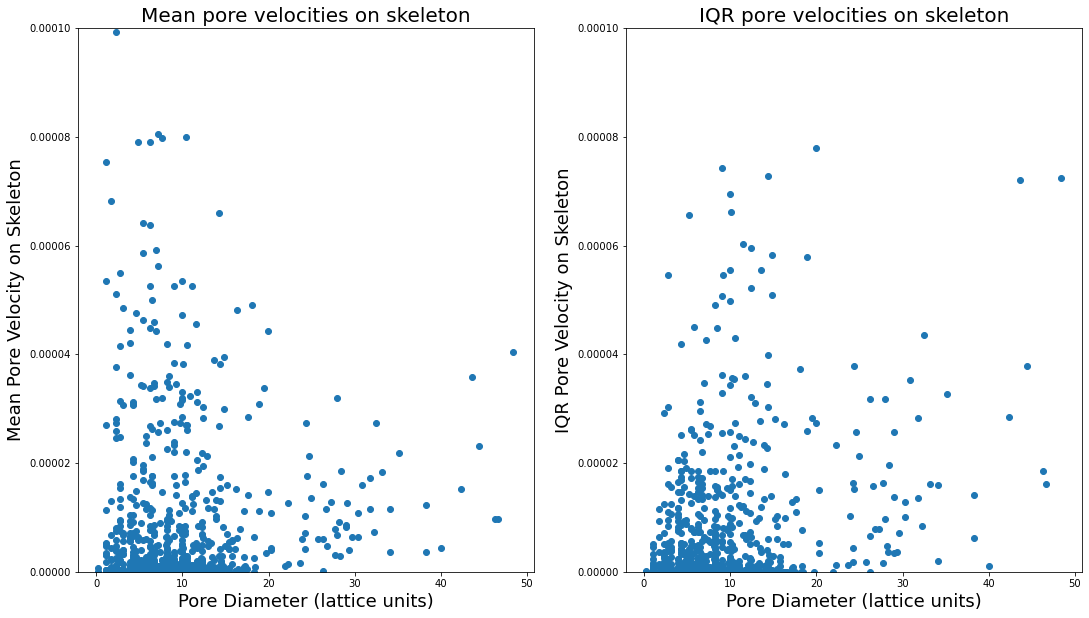

In [85]:
yMax = 0.0001

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
axes[0].scatter(secondarySkeletonPoreDiam, secondaryMeanPoreVelocity)
axes[0].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[0].set_ylabel('Mean Pore Velocity on Skeleton', fontsize=18)
axes[0].set_title('Mean pore velocities on skeleton', fontsize=20)
axes[0].set_ylim([0,yMax])

axes[1].scatter(secondarySkeletonPoreDiam, secondary_IQR_PoreVelocity)
axes[1].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[1].set_ylabel('IQR Pore Velocity on Skeleton', fontsize=18)
axes[1].set_title('IQR pore velocities on skeleton', fontsize=20)
axes[1].set_ylim([0,yMax])

fig.savefig('secondaryPoreVelAveraging.png')

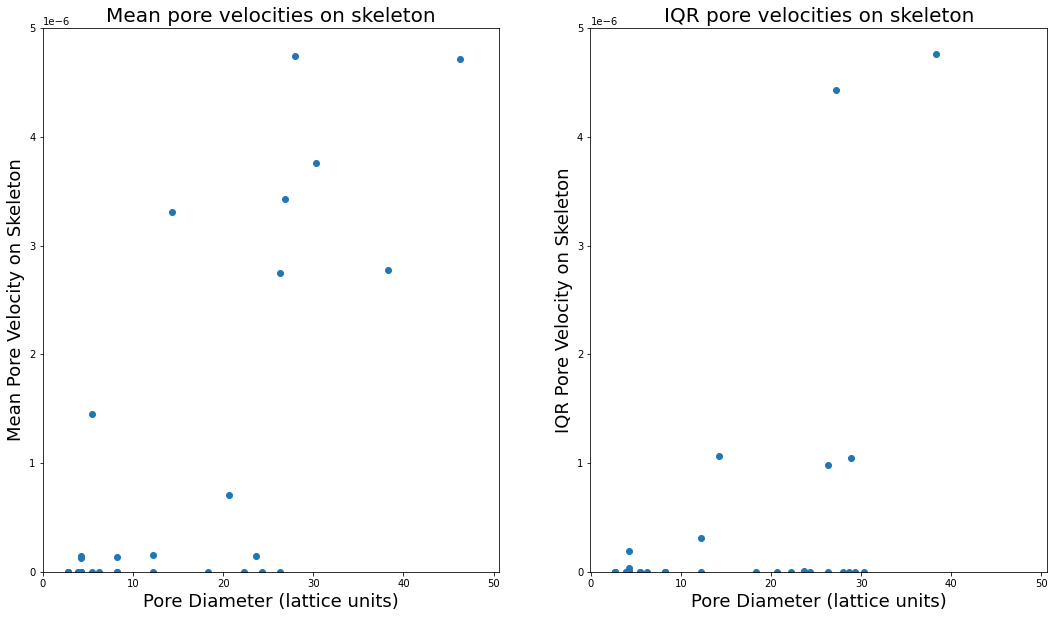

In [93]:
yMax = 0.000005

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
axes[0].scatter(primarySkeletonPoreDiam, primaryMeanPoreVelocity)
axes[0].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[0].set_ylabel('Mean Pore Velocity on Skeleton', fontsize=18)
axes[0].set_title('Mean pore velocities on skeleton', fontsize=20)
axes[0].set_ylim([0,yMax])

axes[1].scatter(primarySkeletonPoreDiam, primary_IQR_PoreVelocity)
axes[1].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[1].set_ylabel('IQR Pore Velocity on Skeleton', fontsize=18)
axes[1].set_title('IQR pore velocities on skeleton', fontsize=20)
axes[1].set_ylim([0,yMax])

fig.savefig('primaryPoreVelAveraging.png')





## Try histogram of IQR with custom bins and pore diam filt

Small pores
868
just large pores
54


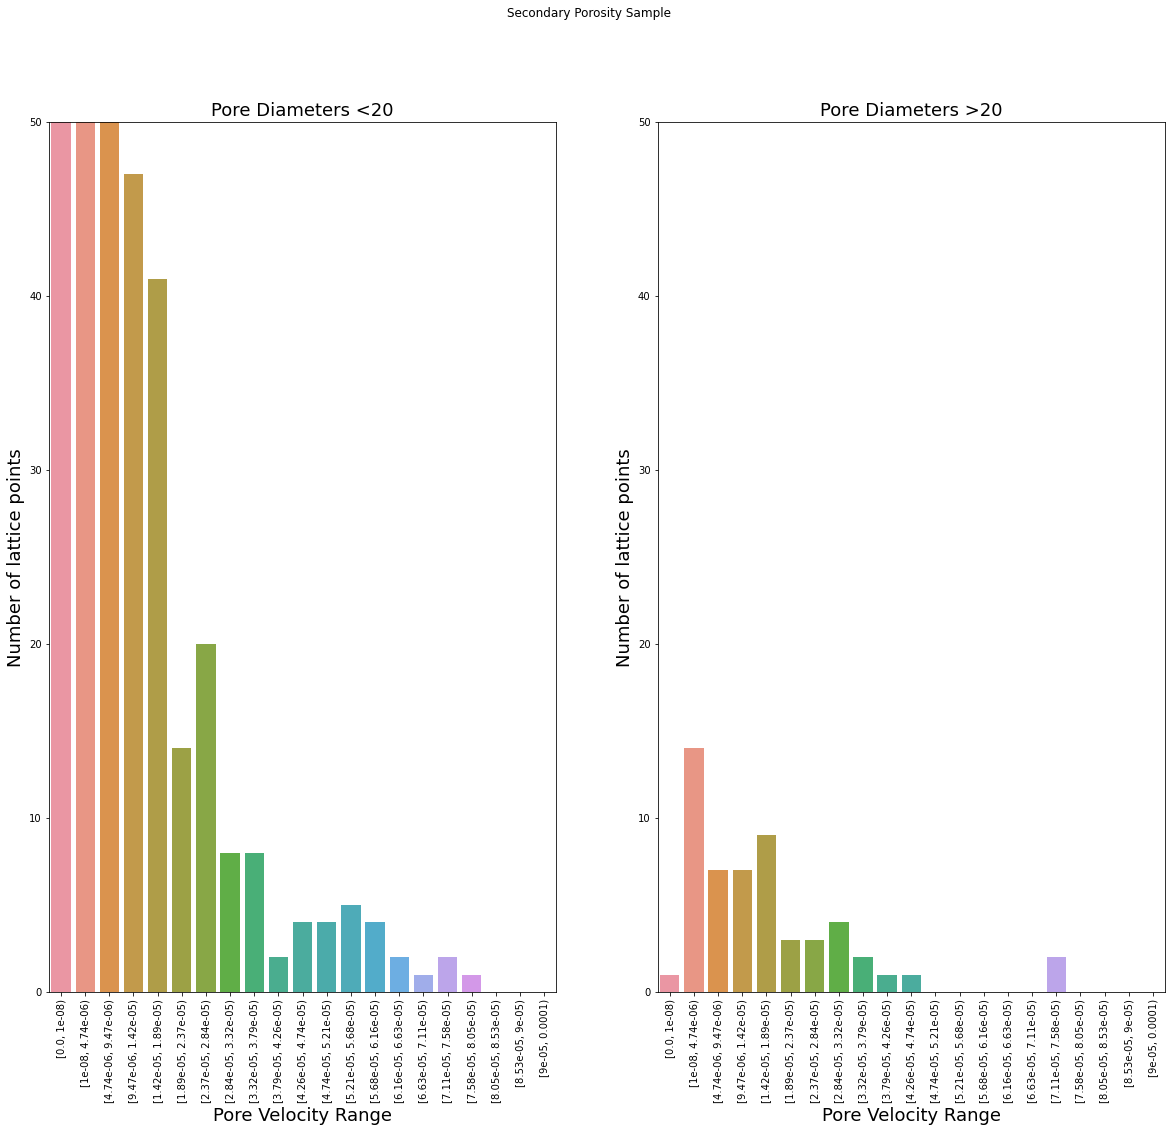

In [102]:
poreDiamThresh = 20

IQRFilt = secondary_IQR_PoreVelocity[secondarySkeletonPoreDiam < poreDiamThresh]
# number of large pores
numSmallPores = secondarySkeletonPoreDiam[secondarySkeletonPoreDiam < poreDiamThresh]
print('Small pores')
print(len(numSmallPores))

bins = np.linspace(0, 0.00009, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 0.0001)
bins = np.insert(bins, 1, 0.00000001)

df_small = pd.DataFrame({'skelVel': IQRFilt,
                        'vel_group': pd.cut(IQRFilt, bins=bins, right=False)})


############################################################
IQRFilt = secondary_IQR_PoreVelocity[secondarySkeletonPoreDiam > poreDiamThresh]
# number of large pores
numLargePores = secondarySkeletonPoreDiam[secondarySkeletonPoreDiam > poreDiamThresh]
print('just large pores')
print(len(numLargePores))

df_large = pd.DataFrame({'skelVel': IQRFilt,
                        'vel_group': pd.cut(IQRFilt, bins=bins, right=False)})

############################################################

fig, axes = plt.subplots(1, 2, figsize=(20, 16))
fig.suptitle('Secondary Porosity Sample')

sns.countplot(data=df_small,x='vel_group',ax=axes[0] )
sns.countplot(data=df_large,x='vel_group',ax=axes[1])

axes[0].set_title('Pore Diameters <'+str(poreDiamThresh), fontsize=18)
axes[1].set_title('Pore Diameters >'+str(poreDiamThresh), fontsize=18)
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[0].set_ylim([0,50])
axes[1].set_ylim([0,50])

axes[0].set_xlabel('Pore Velocity Range', fontsize=18)
axes[0].set_ylabel('Number of lattice points', fontsize=18)

axes[1].set_xlabel('Pore Velocity Range', fontsize=18)
axes[1].set_ylabel('Number of lattice points', fontsize=18)

fig.savefig('secondaryCustomHistIQR.png')

Small pores
39
just large pores
54


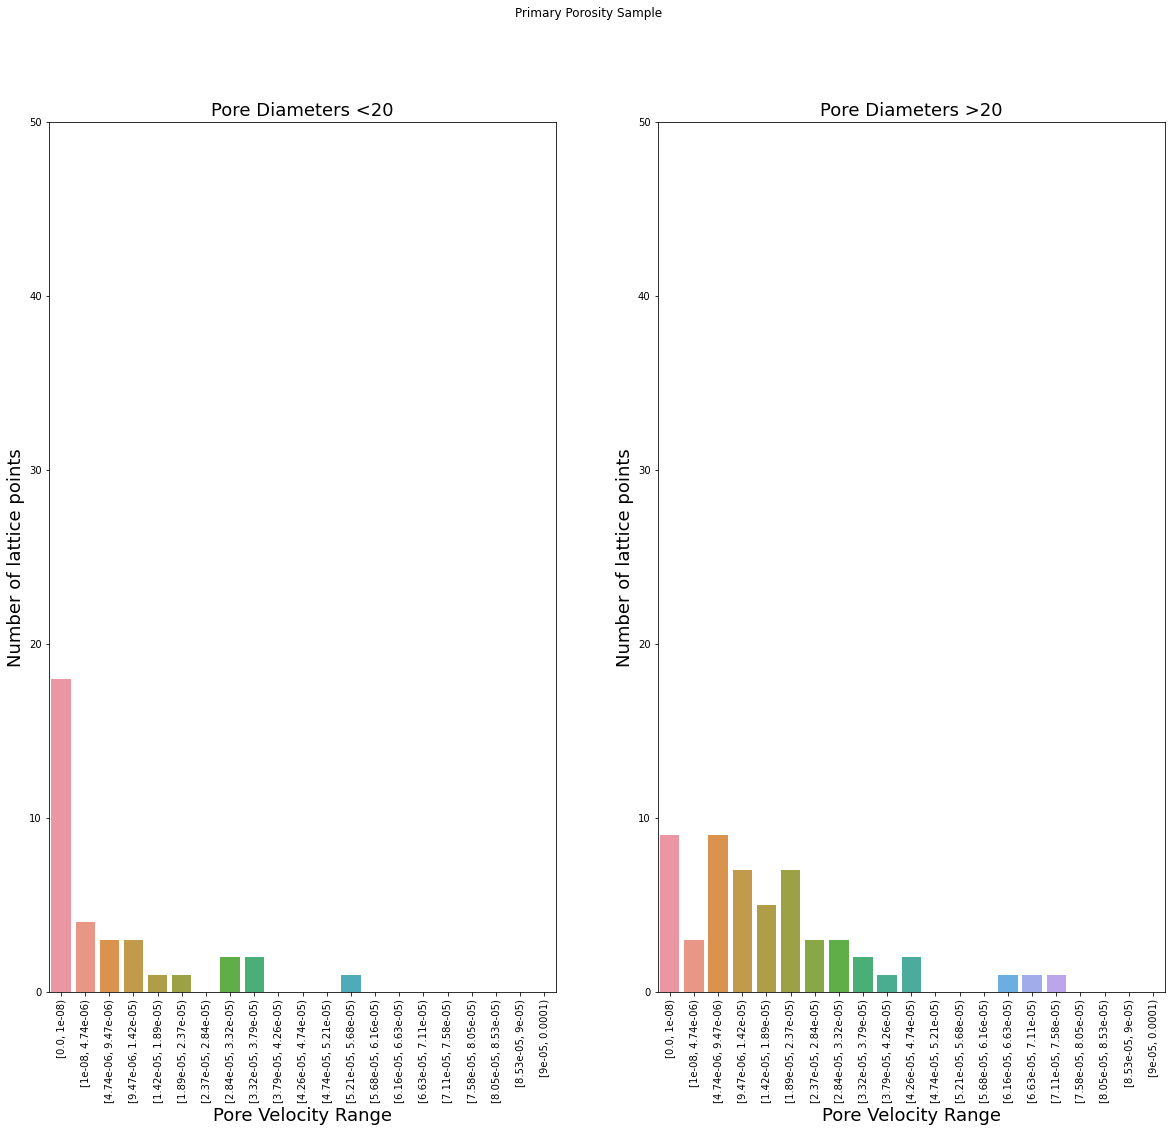

In [104]:
poreDiamThresh = 20

IQRFilt = primary_IQR_PoreVelocity[primarySkeletonPoreDiam < poreDiamThresh]
# number of large pores
numSmallPores = primarySkeletonPoreDiam[primarySkeletonPoreDiam < poreDiamThresh]
print('Small pores')
print(len(numSmallPores))

bins = np.linspace(0, 0.00009, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 0.0001)
bins = np.insert(bins, 1, 0.00000001)

df_small = pd.DataFrame({'skelVel': IQRFilt,
                        'vel_group': pd.cut(IQRFilt, bins=bins, right=False)})


############################################################
IQRFilt = primary_IQR_PoreVelocity[primarySkeletonPoreDiam > poreDiamThresh]
# number of large pores
numLargePores = primarySkeletonPoreDiam[primarySkeletonPoreDiam > poreDiamThresh]
print('just large pores')
print(len(numLargePores))

df_large = pd.DataFrame({'skelVel': IQRFilt,
                        'vel_group': pd.cut(IQRFilt, bins=bins, right=False)})

############################################################

fig, axes = plt.subplots(1, 2, figsize=(20, 16))
fig.suptitle('Primary Porosity Sample')

sns.countplot(data=df_small,x='vel_group',ax=axes[0] )
sns.countplot(data=df_large,x='vel_group',ax=axes[1])

axes[0].set_title('Pore Diameters <'+str(poreDiamThresh), fontsize=18)
axes[1].set_title('Pore Diameters >'+str(poreDiamThresh), fontsize=18)
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[0].set_ylim([0,50])
axes[1].set_ylim([0,50])

axes[0].set_xlabel('Pore Velocity Range', fontsize=18)
axes[0].set_ylabel('Number of lattice points', fontsize=18)

axes[1].set_xlabel('Pore Velocity Range', fontsize=18)
axes[1].set_ylabel('Number of lattice points', fontsize=18)

fig.savefig('primaryCustomHistIQR.png')

Separate all pores with low velocity


In [105]:
# Best choice for this? hardcoded to 0 per discussion on 4/2
# Based on plots, trying 1.42 * 10^-5 on 4/19
noFlowVelCutoff = 1.42 * 10 ** float(-5) # 0.5 * 10 ** float(-5)
print(noFlowVelCutoff)

1.4200000000000001e-05


In [66]:
poreRegions, indices = np.unique(secondaryPoreRegionSkeleton, return_index='True')
noFlowRegions = skeletonPoreRegion[IQR_PoreVelocity == 0]
noFlowPoreDiam = skeletonPoreDiam[IQR_PoreVelocity == 0]
noFlowImage = np.zeros(secondaryImage.shape)
flowImage = np.copy(secondaryImage)
noFlowRegionVector = []

# This is unnecessary

# for a in tqdm.tqdm(range(0,len(noFlowRegions)), 'Main loop'):
#     regionInd = noFlowRegions[a]
#     print(regionInd)
#     noFlowRegionVector = np.append(noFlowRegionVector, regionInd)
#     #print('This is a no flow region:', regionInd)
#     noFlowImage[secondaryRegions == regionInd] =  1
#     flowImage[secondaryRegions == regionInd] = 0



### Select pores that don't flow with large pore sizes

In [69]:

filtNoFlowPoreDiam = noFlowPoreDiam[noFlowPoreDiam > poreDiamThresh]

# plt.scatter(secondaryPoreDiamSkeletonFilt, secondaryVelocitiesSkeletonFilt)
# plt.xlabel('Pore Diameter (lattice units)', fontsize=18)
# plt.ylabel('Pore Velocity on Skeleton ', fontsize=18)
# plt.title('All pore velocities on skeleton', fontsize=20)
#
# fig.savefig('allPoreVelocities.png')
